In [5]:
import pandas as pd

df = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/5_1_aggregated.csv')
df2 = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/5_2_aggregated.csv')
df3 = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/5_3_aggregated.csv')

In [6]:
df_list = [df, df2, df3]

combined_df = pd.concat(df_list, ignore_index=True)

combined_df.to_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/5+.csv', index=False)

In [8]:
df = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/4.csv')
df2 = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/5+.csv')
df_list = [df, df2]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/HrbridCVDV.csv', index=False)

In [9]:
df = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/chocoq-binary电路分析/4_layer_1.csv')
df2 = pd.read_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/chocoq-binary电路分析/5_layer_1.csv')
df_list = [df, df2]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv('/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/ChocoQ.csv', index=False)

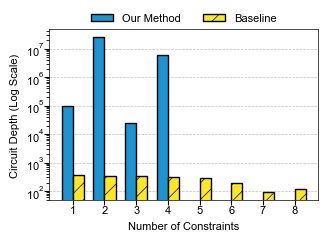

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 样式设置 (保持学术风格) ---
width_pt = 240
inches_per_pt = 1 / 72.27
fig_width = width_pt * inches_per_pt
fig_height = fig_width * 0.75

plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 8,
    "figure.figsize": (fig_width, fig_height),
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "axes.linewidth": 0.5,
    "hatch.linewidth": 0.5,
    "grid.alpha": 0.5,
})

# --- 2. 数据读取与处理函数 ---
def process_data(file_path, label_name):
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"读取 {label_name} 失败: {e}")
        return None

    # [关键] 检查是否有 Constraint_Num 列
    if 'Constraint_Num' not in df.columns:
        print(f"提示: {label_name} 缺少 'Constraint_Num' 列，正在尝试自动生成...")
        # 假设数据是按顺序排列的，将其等分为 5 组，对应 5 个约束条件
        # 如果您的数据顺序不同，请务必修改此处逻辑！
        n_rows = len(df)
        constraints = [5, 20, 35, 50, 65] 
        # 创建一个重复的数组，例如 [5,5,.., 20,20,..]
        chunk_size = int(np.ceil(n_rows / len(constraints)))
        assigned_constraints = []
        for c in constraints:
            assigned_constraints.extend([c] * chunk_size)
        # 截取到实际行数
        df['Constraint_Num'] = assigned_constraints[:n_rows]

    # 确保 Depth 是数值
    df['Depth'] = pd.to_numeric(df['Depth'], errors='coerce')
    df = df.dropna(subset=['Depth'])

    # [关键] 计算几何平均值 (Geometric Mean)
    # 应对超大数值：先取 Log10 求平均，再还原
    df['log_depth'] = np.log10(df['Depth'])
    grouped = df.groupby('Constraint_Num')['log_depth'].mean()
    geo_mean = 10 ** grouped
    
    return geo_mean

# --- 3. 读取数据 ---
# 请替换为您真实的文件路径
file1 = '/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/HrbridCVDV.csv'   # 您的新方法文件
file2 = '/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/ChocoQ.csv'    # 您的对比方法文件 (MIP/ChocoQ)

# 读取并计算
data1 = process_data(file1, "Our Method")
data2 = process_data(file2, "Baseline")

# 确保两个数据的 Index (约束数) 一致，取并集
all_constraints = sorted(list(set(data1.index) | set(data2.index)))

# 对齐数据 (如果有缺失值填 NaN)
y1 = [data1.get(c, 0) for c in all_constraints]
y2 = [data2.get(c, 0) for c in all_constraints]

# --- 4. 绘制分组柱状图 ---
fig, ax = plt.subplots()

x = np.arange(len(all_constraints))
bar_width = 0.35

# 绘制两组柱子
# zorder=3 让柱子显示在网格线之上
rects1 = ax.bar(x - bar_width/2, y1, bar_width, label='Our Method', color='#1D93D0', edgecolor='black', zorder=3)
rects2 = ax.bar(x + bar_width/2, y2, bar_width, label='Baseline', color='#FDE725', edgecolor='black', hatch='//', zorder=3)

# --- 5. 轴与标签设置 ---
ax.set_xlabel('Number of Constraints')
ax.set_ylabel('Circuit Depth (Log Scale)')
ax.set_yscale('log')  # [重要] 开启对数坐标

ax.set_xticks(x)
ax.set_xticklabels(all_constraints)

# Y轴网格线
ax.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5, zorder=0)

# 图例设置 (顶部居中)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.15),
    ncol=2, 
    frameon=False # 去掉图例边框更简洁，或者设为True
)

plt.tight_layout()
plt.show()

=== 计算结果预览 ===
   Var_Num  Hybrid_GeoMean  ChocoQ_GeoMean
0        4   137452.780960      206.132694
1        5   567516.775141      357.110098


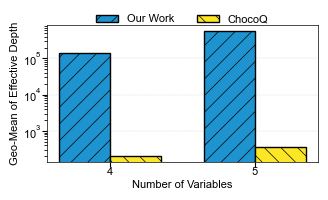

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ==========================================
# 1. 定义几何平均函数
# ==========================================
def geometric_mean(series):
    # 过滤掉 NaN 和 <= 0 的值 (防止 log(0) 报错)
    clean_data = series.dropna()
    clean_data = clean_data[clean_data > 0]
    
    if len(clean_data) == 0:
        return np.nan
        
    return np.exp(np.mean(np.log(clean_data)))

# ==========================================
# 2. 读取与预处理数据
# ==========================================
file1_path = '/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/HrbridCVDV.csv'   # HybridCVDV 数据
file2_path = '/Users/jinboyu/Documents/GitHub/RL-for-hybrid-CV-DV-complier/experiment/ChocoQ.csv' # ChocoQ 数据

df1 = pd.read_csv(file1_path) # HybridCVDV
df2 = pd.read_csv(file2_path) # ChocoQ

# --- 数据清洗 (转数字) ---
cols_needed_1 = ['Var_Num', 'Depth', 'Single_Gate', 'Two_Gate']
cols_needed_2 = ['Var_Num', 'Depth']

for col in cols_needed_1:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

for col in cols_needed_2:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# 删除 Var_Num 为空的无效行
df1.dropna(subset=['Var_Num'], inplace=True)
df2.dropna(subset=['Var_Num'], inplace=True)

# ==========================================
# 3. 计算特定深度指标
# ==========================================

# --- A. 处理 HybridCVDV (df1) ---
# 逻辑：Effective Depth = (Two / (Two + Single)) * Depth
df1['Total_Gates'] = df1['Two_Gate'] + df1['Single_Gate']

# 防止除以 0，如果总门数为0，则设为 NaN 或 0
df1 = df1[df1['Total_Gates'] > 0].copy() 

df1['Ratio'] = df1['Two_Gate'] / df1['Total_Gates']
df1['Effective_Depth'] = df1['Ratio'] * df1['Depth']

# --- B. 处理 ChocoQ (df2) ---
# 逻辑：直接使用 Depth
df2['Effective_Depth'] = df2['Depth']

# ==========================================
# 4. 按 Var_Num 计算几何平均
# ==========================================
# HybridCVDV 聚合
df1_agg = df1.groupby('Var_Num')['Effective_Depth'].apply(geometric_mean).reset_index()
df1_agg.rename(columns={'Effective_Depth': 'Hybrid_GeoMean'}, inplace=True)

# ChocoQ 聚合
df2_agg = df2.groupby('Var_Num')['Effective_Depth'].apply(geometric_mean).reset_index()
df2_agg.rename(columns={'Effective_Depth': 'ChocoQ_GeoMean'}, inplace=True)

# 合并数据
plot_data = pd.merge(df1_agg, df2_agg, on='Var_Num', how='inner')
plot_data.sort_values('Var_Num', inplace=True)

print("=== 计算结果预览 ===")
print(plot_data.head())

# ==========================================
# 5. 绘图
# ==========================================
width_pt = 240
inches_per_pt = 1 / 72.27
fig_width = width_pt * inches_per_pt
fig_height = fig_width / 1.6 

plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 8,
    "figure.figsize": (fig_width, fig_height),
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.major.pad": 0.3,
    "ytick.major.pad": 0.3,
    "legend.fontsize": 8,
    "axes.titlesize": 8,
    "grid.linewidth": 0.2,
    "grid.alpha": 0.5,
    "grid.color": "gray",
    "axes.linewidth": 0.5,
    "hatch.linewidth": 0.5,
})

fig, ax = plt.subplots(1, 1)
ax.grid(True, axis='y', linestyle='--')
ax.set_yscale('log')

# 准备 X 轴
x_labels = plot_data['Var_Num'].astype(int).astype(str)
x = np.arange(len(x_labels))
bar_width = 0.35

colors = {'Hybrid': '#1D93D0', 'ChocoQ': '#FDE725'}

# 绘制柱状图
# HybridCVDV (Our Work)
ax.bar(x - bar_width/2, plot_data['Hybrid_GeoMean'], width=bar_width, 
       color=colors['Hybrid'], edgecolor='black', hatch='//', label='Our Work')

# ChocoQ
ax.bar(x + bar_width/2, plot_data['ChocoQ_GeoMean'], width=bar_width, 
       color=colors['ChocoQ'], edgecolor='black', hatch='\\\\', label='ChocoQ')

# 设置轴标签
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Number of Variables', labelpad=2)
ax.set_ylabel('Geo-Mean of Effective Depth', labelpad=2)

# 图例
legend_handles = [
    Patch(facecolor=colors['Hybrid'], edgecolor='black', hatch='//', label='Our Work'),
    Patch(facecolor=colors['ChocoQ'], edgecolor='black', hatch='\\\\', label='ChocoQ')
]

legend = ax.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    framealpha=1,
    ncol=2,
    frameon=False,
    edgecolor='black'
)

plt.tight_layout()
plt.show()

=== 聚合后数据预览 ===
   Var_Num   Our_GeoMean  ChocoQ_GeoMean
0        4   9277.507798      232.299865
1        5  14423.280761      369.577371


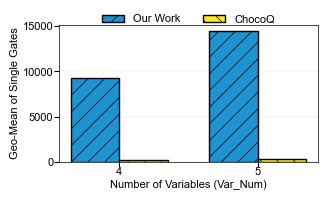

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ==========================================
# 1. 定义几何平均函数
# ==========================================
def geometric_mean(series):
    # 移除空值和小于等于0的值(对数对0/负数无定义，若包含0几何平均即为0)
    # 这里假设门数量通常 > 0。如果确实有0，需要根据物理意义决定是否返回0或加个极小值
    clean_data = series.dropna()
    clean_data = clean_data[clean_data > 0]
    
    if len(clean_data) == 0:
        return np.nan
        
    return np.exp(np.mean(np.log(clean_data)))

# ==========================================
# 2. 读取与预处理数据
# ==========================================
file1_path = 'HrbridCVDV.csv'   # 替换你的文件名
file2_path = 'ChocoQ.csv' # 替换你的文件名

# 读取
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# --- 关键步骤：清洗数据 (解决 TypeError) ---
# 强制转为数字，错误的变成 NaN
df1['Var_Num'] = pd.to_numeric(df1['Var_Num'], errors='coerce')
df1['Single_Qumode_Gate'] = pd.to_numeric(df1['Single_Qumode_Gate'], errors='coerce')

df2['Var_Num'] = pd.to_numeric(df2['Var_Num'], errors='coerce')
df2['Single_Qubit_Gate'] = pd.to_numeric(df2['Single_Qubit_Gate'], errors='coerce')

# 删除 Var_Num 为空的行
df1.dropna(subset=['Var_Num'], inplace=True)
df2.dropna(subset=['Var_Num'], inplace=True)

# ==========================================
# 3. 按 Var_Num 分组并计算几何平均
# ==========================================
# df1 (Our Method)
df1_agg = df1.groupby('Var_Num')['Single_Qumode_Gate'].apply(geometric_mean).reset_index()
df1_agg.rename(columns={'Single_Qumode_Gate': 'Our_GeoMean'}, inplace=True)

# df2 (ChocoQ)
df2_agg = df2.groupby('Var_Num')['Single_Qubit_Gate'].apply(geometric_mean).reset_index()
df2_agg.rename(columns={'Single_Qubit_Gate': 'ChocoQ_GeoMean'}, inplace=True)

# 合并结果
plot_data = pd.merge(df1_agg, df2_agg, on='Var_Num', how='inner')
plot_data.sort_values('Var_Num', inplace=True)

print("=== 聚合后数据预览 ===")
print(plot_data.head())

# ==========================================
# 4. 绘图 (应用你的 Matplotlib 风格)
# ==========================================
width_pt = 240
inches_per_pt = 1 / 72.27
fig_width = width_pt * inches_per_pt
fig_height = fig_width / 1.6 

plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 8,
    "figure.figsize": (fig_width, fig_height),
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.major.pad": 0.3,
    "ytick.major.pad": 0.3,
    "legend.fontsize": 8,
    "axes.titlesize": 8,
    "lines.markersize": 2.5,
    "lines.linewidth": 0.7,
    "grid.linewidth": 0.2,
    "grid.alpha": 0.5,
    "grid.color": "gray",
    "axes.linewidth": 0.5,
    "hatch.linewidth": 0.5,
})

fig, ax = plt.subplots(1, 1)
ax.grid(True, axis='y', linestyle='--')

# 准备数据
x_labels = plot_data['Var_Num'].astype(int).astype(str) # 将 Var_Num 转为字符串做标签
x = np.arange(len(x_labels))
bar_width = 0.35

# 定义颜色和样式
colors = {'Our': '#1D93D0', 'ChocoQ': '#FDE725'}

# 绘制柱状图
rects1 = ax.bar(x - bar_width/2, plot_data['Our_GeoMean'], width=bar_width, 
                color=colors['Our'], edgecolor='black', hatch='//', label='Our (Qumode)')

rects2 = ax.bar(x + bar_width/2, plot_data['ChocoQ_GeoMean'], width=bar_width, 
                color=colors['ChocoQ'], edgecolor='black', hatch='\\\\', label='ChocoQ (Qubit)')

# 设置坐标轴
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Number of Variables (Var_Num)', labelpad=2)
ax.set_ylabel('Geo-Mean of Single Gates', labelpad=2)

# 设置图例 (顶部居中)
legend_handles = [
    Patch(facecolor=colors['Our'], edgecolor='black', hatch='//', label='Our Work'),
    Patch(facecolor=colors['ChocoQ'], edgecolor='black', hatch='\\\\', label='ChocoQ')
]

legend = ax.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    framealpha=1,
    ncol=2,
    frameon=False, # 去掉边框看起来更干净，如需保留改为True
    edgecolor='black'
)

# 调整布局
plt.tight_layout() # 自动调整边距
plt.show()